In [1]:
import os
import sys
import glob

import h5py
import nibabel as nib
import numpy as np


sys.path.append('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/tta_uia_segmentation/src')
from preprocessing.utils import get_filepaths

## Correct the Aneurysm label on image 04270916_VS_AComm

### Raw

In [6]:
img_path = '/scratch_net/biwidl319/jbermeo/data/raw/USZ/04270916_VS_AComm_Checked'

In [7]:
os.listdir(img_path)

['04270916_VS_AComm_Checked_seg.nii.gz',
 '04270916_VS_AComm_Checked_tof.nii.gz']

In [12]:
seg = nib.load(os.path.join(img_path, '04270916_VS_AComm_Checked_seg.nii.gz'))

In [16]:
# Remap label 11 to 4
seg_data = seg.get_fdata()
seg_data[seg_data == 11] = 4
seg_data = seg_data.astype(np.uint8)
nib.save(nib.Nifti1Image(seg_data, seg.affine, seg.header), os.path.join(img_path, '04270916_VS_AComm_Checked_seg_corrected.nii.gz'))

In [17]:
np.unique(seg_data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       19], dtype=uint8)

### Resampled

In [18]:
img_path = '/scratch_net/biwidl319/jbermeo/data/preprocessed/1_resampled/USZ/04270916_VS_AComm_Checked'

In [19]:
seg = nib.load(os.path.join(img_path, '04270916_VS_AComm_Checked_seg.nii.gz'))

In [21]:
seg_data = seg.get_fdata()
seg_data[seg_data == 11] = 4
seg_data = seg_data.astype(np.uint8)
nib.save(nib.Nifti1Image(seg_data, seg.affine, seg.header), os.path.join(img_path, '04270916_VS_AComm_Checked_seg_corrected.nii.gz'))

In [ ]:
np.unique(seg_data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       19], dtype=uint8)

## Check distribution of field of views on resample images

In [51]:
a = get_filepaths(preprocessed=True, path_to_dir='/scratch_net/biwidl319/jbermeo/data/preprocessed/1_resampled/Lausanne', every_scan_has_seg=False)

In [53]:
shapes = list()
for idx, img_fps in a.items():
    img = nib.load(img_fps['tof'])
    shapes.append(img.shape)
    
    # print pixel spacing
    print(img.header.get_zooms())
    

In [33]:
# USZ
np.median(np.array(shapes), axis=0)

array([566., 666., 181.])

In [39]:
# ADAM
np.median(np.array(shapes), axis=0)

array([666., 666., 116.])

In [54]:
# Lausanne
np.median(np.array(shapes), axis=0)

array([570., 700., 166.])

(array([ 3.,  1., 18.,  7.,  9.,  1.,  0.,  0.,  7., 10.]),
 array([499. , 519.1, 539.2, 559.3, 579.4, 599.5, 619.6, 639.7, 659.8,
        679.9, 700. ]),
 <BarContainer object of 10 artists>)

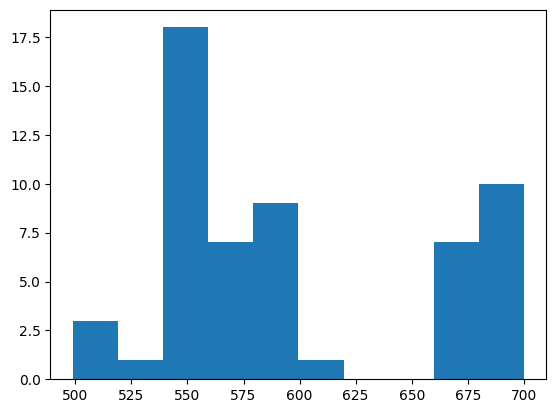

In [60]:
# plot histogram
import matplotlib.pyplot as plt
plt.hist(np.array(shapes)[:, 0],)

(array([ 1.,  0.,  0.,  3.,  0.,  0., 39.,  0., 12.,  1.]),
 array([600. , 616.6, 633.2, 649.8, 666.4, 683. , 699.6, 716.2, 732.8,
        749.4, 766. ]),
 <BarContainer object of 10 artists>)

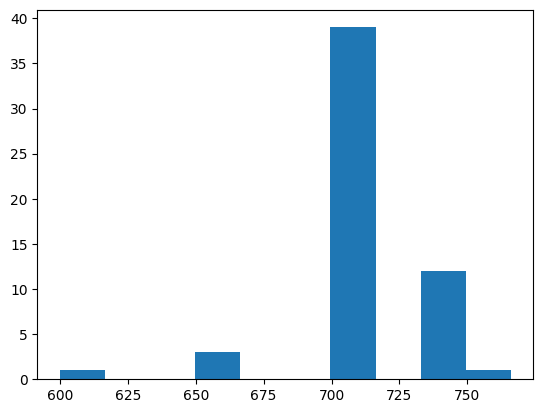

In [62]:
plt.hist(np.array(shapes)[:, 1])

### Check how the dataset class is working

In [2]:
import sys
sys.path.append('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/tta_uia_segmentation/src')

In [32]:
from dataset.dataset_h5 import DatasetH5
import matplotlib.pyplot as plt
import yaml
from pprint import pprint

In [27]:
config = yaml.load(open('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/training_hcp_t1w.yaml', 'r'),
          Loader=yaml.FullLoader)

In [34]:
pprint(config['segmentation'])

{'augmentation': {'alpha': 1000,
                  'brightness_max': 0.1,
                  'brightness_min': 0.0,
                  'da_ratio': 0.25,
                  'gamma_max': 2.0,
                  'gamma_min': 0.5,
                  'noise_mean': 0.0,
                  'noise_std': 0.1,
                  'rot_max': 10,
                  'rot_min': -10,
                  'scale_max': 1.1,
                  'scale_min': 0.9,
                  'sigma': 20,
                  'trans_max': 10,
                  'trans_min': -10},
 'batch_size': 16,
 'bg_suppression_opts': {'bg_value': -0.5,
                         'bg_value_max': 1,
                         'bg_value_min': -0.5,
                         'hole_filling': True,
                         'mask_source': 'thresholding',
                         'thresholding': 'otsu',
                         'type': 'fixed_value'},
 'dataset': 'hcp_t1',
 'epochs': 150,
 'image_size': [1, 256, 256],
 'learning_rate': 0.001,
 'logdir': '/sc

In [47]:
bg_suppression_opts = config['segmentation']['bg_suppression_opts']
pprint(bg_suppression_opts)

{'bg_value': -0.5,
 'bg_value_max': 1,
 'bg_value_min': -0.5,
 'hole_filling': True,
 'mask_source': 'thresholding',
 'thresholding': 'otsu',
 'type': 'fixed_value'}


In [67]:
bg_suppression_opts['hole_filling'] = False
bg_suppression_opts['mask_source'] = 'ground_truth'

In [68]:
split = 'train'
ds = DatasetH5(
    h5_filepath='/scratch_net/biwidl319/jbermeo/data/preprocessed/UIA_segmentation/USZ.h5',
    fold=0,
    split=split,
    n_classes=21,
    rescale_factor=None,
    aug_params=config['segmentation']['augmentation'],
    deformation=None,
    bg_suppression_opts=config['segmentation']['bg_suppression_opts'],
    seed=0,
)

In [69]:
for a in ds:
    break

In [70]:
a[4]

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

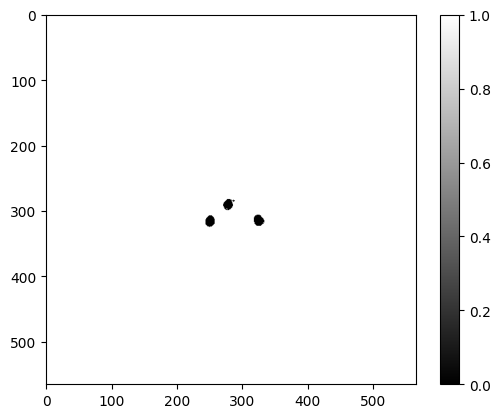

In [71]:
# Print image with a color bar showing the pixel values
plt.imshow(a[4][60, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar()

## Check the format of the h5 files

In [116]:
import os
import sys

import h5py

In [124]:
h5f = h5py.File('/scratch_net/biwidl319/jbermeo/data/preprocessed/UIA_segmentation/USZ.h5', 'r')

In [128]:
sys.getsizeof(h5f)

48

In [129]:
h5f.keys()

<KeysViewHDF5 ['data', 'data_leq_4mm', 'folds', 'ids']>

In [130]:
h5f['ids'][:]

array([b'10107525-MCA-new-Colors', b'10811755_CC_AComm_NEW',
       b'60213089-MCA-ICA-NEW', b'10764179-MCA-NEW_DONE',
       b'11096773_IB_PComm', b'60201588-MCA-NEW_DONE',
       b'10731286-ICA-links-NEW', b'11047954_LM_Pericallosa',
       b'10104830_ZG_ComplexICA_Checked',
       b'10299485_BMM_AComm_MCA_Checked', b'10266790_CL_ICA_Checked',
       b'10599468-AComm-new', b'10019209_EK_MCA_Checked',
       b'10986737_SH_PICA', b'11092603_GDSCR_MCA',
       b'10480878_HS_PComm_MCA_Checked', b'10102066_KA_AComm_Checked',
       b'10083905_GLUK_MCA_Checked', b'10795198-BA-NEW_DONE',
       b'10820130_MB_MirrorMCA', b'11137190_NM_MA_NEW',
       b'11050151_JT_PICA', b'10600633-AComm-new-Colors',
       b'10704331-AComm-NEW', b'10739823-PComm-links-NEW',
       b'10293987_HMR_AComm_Checked', b'10787757-ACA-NEW_DONE',
       b'08211078_FS_MCA_NEW', b'11140272_DSRMSM_ICA_NEW',
       b'10788543_ZM_MirrorMCA_Checked', b'10919238_GD_MCA',
       b'10731124-MCA-rechts-NEW', b'07767625_LJ_Peri

In [131]:
h5f['folds/fold_0/test_idx'][:]

array([ 2,  4, 10, 11, 26, 30, 32, 33, 35, 43, 45, 48, 51])

In [132]:
h5f['folds/fold_0'].keys()

<KeysViewHDF5 ['test_idx', 'train_dev_idx', 'train_idx', 'val_dev_idx']>

In [133]:
fold = 0 
split = 'train'
ids = h5f['ids'][:]
indexes_of_ids_in_fold = h5f[f'folds/fold_{fold}/{split}_idx'][:]

index_to_id = {new_index: ids[idx_id] for new_index, idx_id in enumerate(indexes_of_ids_in_fold)}
id_to_idx = {id: new_index for new_index, id in index_to_id.items()}

In [134]:
index_to_id

{0: b'10107525-MCA-new-Colors',
 1: b'10811755_CC_AComm_NEW',
 2: b'10764179-MCA-NEW_DONE',
 3: b'60201588-MCA-NEW_DONE',
 4: b'10731286-ICA-links-NEW',
 5: b'11047954_LM_Pericallosa',
 6: b'10104830_ZG_ComplexICA_Checked',
 7: b'10299485_BMM_AComm_MCA_Checked',
 8: b'10019209_EK_MCA_Checked',
 9: b'10986737_SH_PICA',
 10: b'11092603_GDSCR_MCA',
 11: b'10480878_HS_PComm_MCA_Checked',
 12: b'10102066_KA_AComm_Checked',
 13: b'10083905_GLUK_MCA_Checked',
 14: b'10795198-BA-NEW_DONE',
 15: b'10820130_MB_MirrorMCA',
 16: b'11137190_NM_MA_NEW',
 17: b'11050151_JT_PICA',
 18: b'10600633-AComm-new-Colors',
 19: b'10704331-AComm-NEW',
 20: b'10739823-PComm-links-NEW',
 21: b'10293987_HMR_AComm_Checked',
 22: b'08211078_FS_MCA_NEW',
 23: b'11140272_DSRMSM_ICA_NEW',
 24: b'10788543_ZM_MirrorMCA_Checked',
 25: b'10731124-MCA-rechts-NEW',
 26: b'10998664_RJR_BAGiant',
 27: b'02453347_PG_Multiple_Checked',
 28: b'06913083-MCA-NEW',
 29: b'08016046-PComm-NEW_DONE',
 30: b'10804920_ARS_MCA_Checked',


In [135]:
id_to_idx

{b'10107525-MCA-new-Colors': 0,
 b'10811755_CC_AComm_NEW': 1,
 b'10764179-MCA-NEW_DONE': 2,
 b'60201588-MCA-NEW_DONE': 3,
 b'10731286-ICA-links-NEW': 4,
 b'11047954_LM_Pericallosa': 5,
 b'10104830_ZG_ComplexICA_Checked': 6,
 b'10299485_BMM_AComm_MCA_Checked': 7,
 b'10019209_EK_MCA_Checked': 8,
 b'10986737_SH_PICA': 9,
 b'11092603_GDSCR_MCA': 10,
 b'10480878_HS_PComm_MCA_Checked': 11,
 b'10102066_KA_AComm_Checked': 12,
 b'10083905_GLUK_MCA_Checked': 13,
 b'10795198-BA-NEW_DONE': 14,
 b'10820130_MB_MirrorMCA': 15,
 b'11137190_NM_MA_NEW': 16,
 b'11050151_JT_PICA': 17,
 b'10600633-AComm-new-Colors': 18,
 b'10704331-AComm-NEW': 19,
 b'10739823-PComm-links-NEW': 20,
 b'10293987_HMR_AComm_Checked': 21,
 b'08211078_FS_MCA_NEW': 22,
 b'11140272_DSRMSM_ICA_NEW': 23,
 b'10788543_ZM_MirrorMCA_Checked': 24,
 b'10731124-MCA-rechts-NEW': 25,
 b'10998664_RJR_BAGiant': 26,
 b'02453347_PG_Multiple_Checked': 27,
 b'06913083-MCA-NEW': 28,
 b'08016046-PComm-NEW_DONE': 29,
 b'10804920_ARS_MCA_Checked': 30,


In [23]:
print(ids[0])

b'10107525-MCA-new-Colors'


In [137]:
a = h5f['data'][ids[0]]['tof'][:]

In [151]:
index=0
images = h5f['data'][index_to_id[index]]['tof'][:]


In [154]:
images.shape[-2:]

(566, 566)

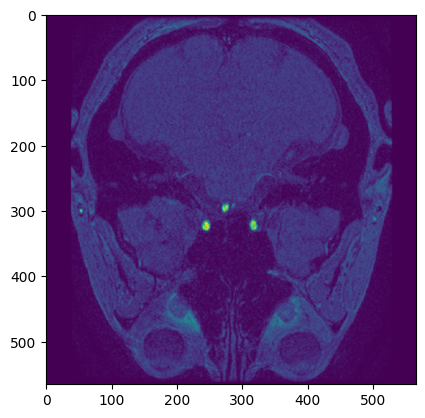

In [152]:
import matplotlib.pyplot as plt 
plt.imshow(images[64, :, None:None])

In [49]:
a = a[0:255, :, :]

In [50]:
a.shape

(255, 566, 111)

In [55]:
b = np.moveaxis(a, -1, 0)
b.shape

(111, 255, 566)

In [56]:
c = np.moveaxis(b, -2, -1)
c.shape

(111, 566, 255)

In [32]:
import numpy as np

In [39]:
a = np.moveaxis(a, -1, 0)

In [45]:
# Store a nifti file
import nibabel as nib
nib.save(nib.Nifti1Image(a, np.eye(4)), 'test_2.nii.gz')

In [46]:
nib.save(nib.Nifti1Image( usz_h5['data'][ids[0]]['tof'][:], np.eye(4)), 'full.nii.gz')

In [47]:
usz_h5['data'][ids[0]]['tof'][:].shape

(566, 566, 111)

In [48]:
ids[0]

b'10107525-MCA-new-Colors'

In [114]:
usz_h5.close()

In [103]:
new = usz_h5['data'][ids[0]]['tof'][:]
new = np.moveaxis(new, -1, 0)
new = np.moveaxis(new, -2, -1)
new = np.rot90(new, k=2, axes=(0, 1))
new.shape

(111, 566, 566)

In [87]:
import numpy as np

# Assuming arr is your 3D array
# Shape of arr: (Depth, Height, Width)

# Step 1: Transpose the array to bring the axis of rotation into the plane
arr_transposed = np.swapaxes(new, 0, 2)  # Swapping first and last axis

# Step 2: Rotate 180 degrees by applying np.rot90 twice or using k=2
arr_rotated = np.rot90(arr_transposed, k=2, axes=(1, 2))  # Rotate in the plane of the last two dimensions

# Step 3: Transpose back to the original orientation
arr_rotated_back = np.swapaxes(arr_rotated, 0, 2)

# Now, arr_rotated_back is the original array rotated 180 degrees along the third-to-last axis
arr_rotated_back.shape

(111, 566, 566)

In [73]:
import matplotlib.pyplot as plt

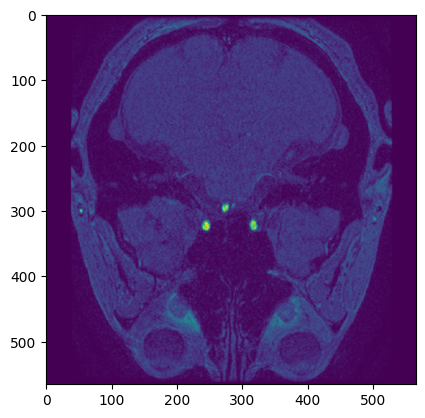

In [115]:
plt.imshow(new[64, :, None:None])